<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_1007_v1(reversed_images_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 6.6 MB/s 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [5]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [6]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [7]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [8]:
def load_dicom(path, size = 128): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [9]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [10]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [11]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [12]:
#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

In [13]:
#augmentation
reversed_X_T1wCE = tf.image.random_flip_left_right(X_T1wCE)
reversed_X_T2w = tf.image.random_flip_left_right(X_T2w)

In [14]:
X = np.concatenate([X_T1wCE, reversed_X_T1wCE, X_T2w, reversed_X_T2w], axis=0)
y = np.concatenate([y_T1wCE, y_T1wCE, y_T2w, y_T2w], axis=0)
train_idt = np.concatenate([train_idt_T1wCE, train_idt_T1wCE, train_idt_T2w, train_idt_T2w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1w, X_test_T1wCE, X_test_T2w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1w, test_idt_T1wCE, test_idt_T2w], axis=0)

In [15]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.1)
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [17]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape

(TensorShape([59416, 64, 64, 1]),
 (59416, 2),
 TensorShape([6602, 64, 64, 1]),
 (6602, 2),
 (59416,),
 (6602,))

In [18]:
X2 = np.concatenate([X_FLAIR, X_T2w, X_T1w, X_T1wCE], axis=0)
y2 = np.concatenate([y_FLAIR, y_T2w, y_T1w, y_T1wCE], axis=0)
train_idt2 = np.concatenate([train_idt_FLAIR, train_idt_T2w, train_idt_T1w, train_idt_T1wCE], axis=0)

In [19]:
X_train2, X_valid2, y_train2, y_valid2, train_idt_train2, train_idt_valid2 = train_test_split(X2, y2, train_idt2, test_size=0.05)

In [20]:
X_train2 = np.expand_dims(X_train2, axis=-1) 
X_valid2 = np.expand_dims(X_valid2, axis=-1)

y_train2 = to_categorical(y_train2) 
y_valid2 = to_categorical(y_valid2)

In [21]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='VALID', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    return model

In [22]:
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 50
N_BATCH = 128
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [23]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [24]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid2, y_valid2),
)

Epoch 1/50
464/464 [==============================] - 37s 44ms/step - loss: 6.1295 - auc: 0.6987 - val_loss: 3.2088 - val_auc: 0.7076
Epoch 2/50
464/464 [==============================] - 20s 42ms/step - loss: 2.0150 - auc: 0.8784 - val_loss: 1.4598 - val_auc: 0.8265
Epoch 3/50
464/464 [==============================] - 20s 42ms/step - loss: 0.9770 - auc: 0.9501 - val_loss: 1.0069 - val_auc: 0.8437
Epoch 4/50
464/464 [==============================] - 20s 42ms/step - loss: 0.6345 - auc: 0.9763 - val_loss: 0.8066 - val_auc: 0.8813
Epoch 5/50
464/464 [==============================] - 20s 42ms/step - loss: 0.4953 - auc: 0.9861 - val_loss: 0.7779 - val_auc: 0.8814
Epoch 6/50
464/464 [==============================] - 20s 42ms/step - loss: 0.4378 - auc: 0.9904 - val_loss: 0.7435 - val_auc: 0.8867
Epoch 7/50
464/464 [==============================] - 20s 42ms/step - loss: 0.3972 - auc: 0.9927 - val_loss: 0.7497 - val_auc: 0.8838
Epoch 8/50
464/464 [==============================] - 20s 42ms

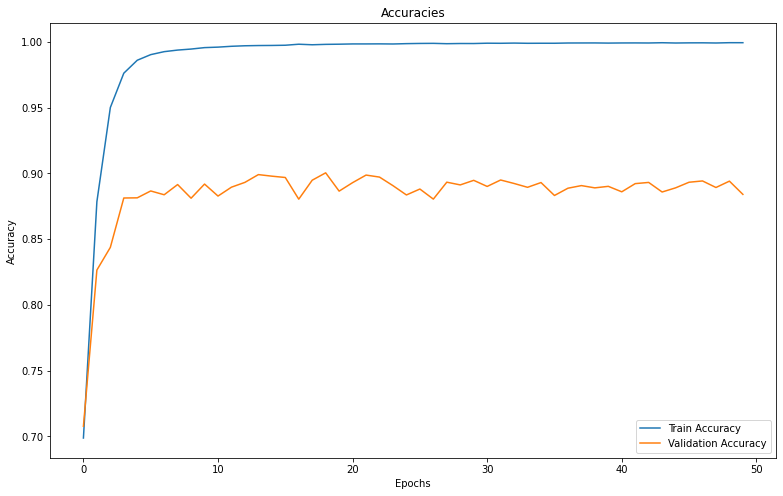

In [25]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

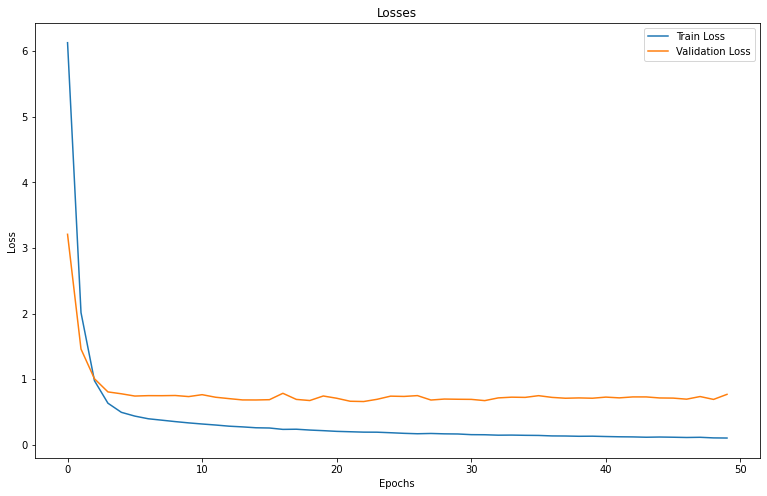

In [26]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.9646317103620474

In [28]:
X = np.concatenate([X_T2w, reversed_X_T2w], axis=0)
y = np.concatenate([y_T2w, y_T2w], axis=0)
train_idt = np.concatenate([train_idt_T2w, train_idt_T2w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1w, X_test_T1wCE, X_test_T2w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1w, test_idt_T1wCE, test_idt_T2w], axis=0)

In [29]:

X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.1)
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [30]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid2, y_valid2),
)

Epoch 1/50
464/464 [==============================] - 13s 27ms/step - loss: 0.1309 - auc: 0.9982 - val_loss: 0.6927 - val_auc: 0.8790
Epoch 2/50
464/464 [==============================] - 12s 27ms/step - loss: 0.1061 - auc: 0.9995 - val_loss: 0.7951 - val_auc: 0.8699
Epoch 3/50
464/464 [==============================] - 12s 27ms/step - loss: 0.0860 - auc: 0.9999 - val_loss: 0.7687 - val_auc: 0.8667
Epoch 4/50
464/464 [==============================] - 12s 27ms/step - loss: 0.0761 - auc: 0.9999 - val_loss: 0.8031 - val_auc: 0.8616
Epoch 5/50
464/464 [==============================] - 12s 27ms/step - loss: 0.0677 - auc: 0.9999 - val_loss: 0.7682 - val_auc: 0.8621
Epoch 6/50
464/464 [==============================] - 12s 27ms/step - loss: 0.0668 - auc: 0.9999 - val_loss: 0.6994 - val_auc: 0.8652
Epoch 7/50
464/464 [==============================] - 12s 27ms/step - loss: 0.0676 - auc: 0.9999 - val_loss: 1.0671 - val_auc: 0.8107
Epoch 8/50
464/464 [==============================] - 12s 27ms

KeyboardInterrupt: ignored

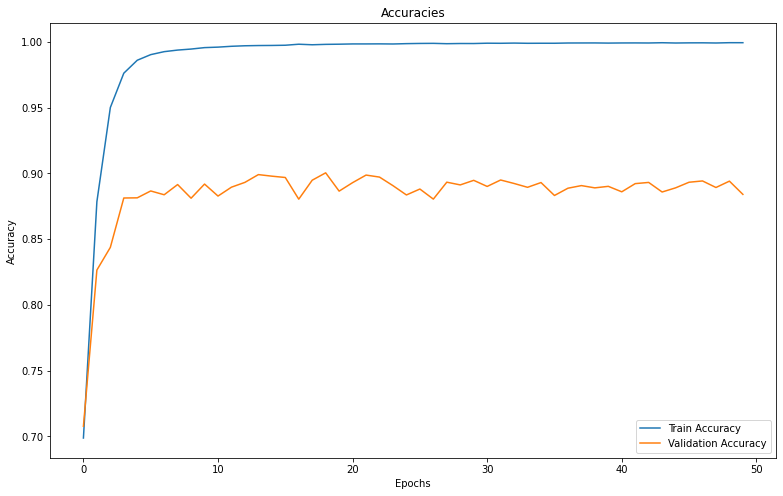

In [31]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

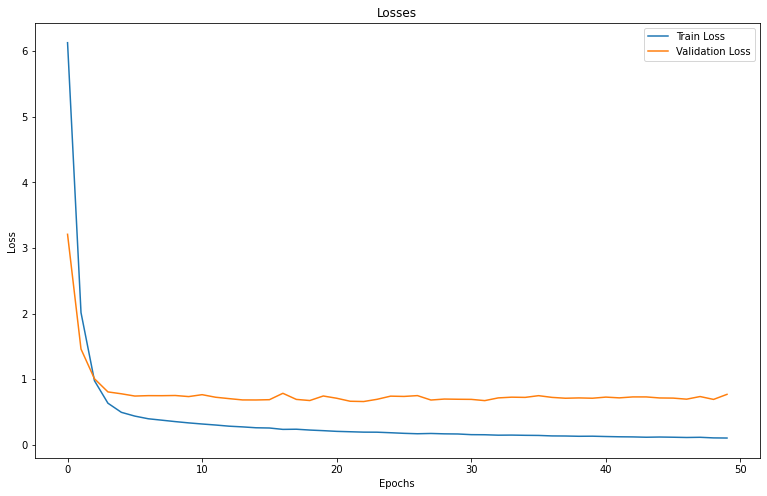

In [32]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 15
N_BATCH = 128
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.00005
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='VALID', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    return model

In [37]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid2, y_valid2),
)

Epoch 1/15
236/236 [==============================] - 44s 167ms/step - loss: 16.2436 - auc_1: 0.7278 - val_loss: 13.5543 - val_auc_1: 0.5739
Epoch 2/15
236/236 [==============================] - 37s 155ms/step - loss: 11.1139 - auc_1: 0.9547 - val_loss: 9.7813 - val_auc_1: 0.7188
Epoch 3/15
236/236 [==============================] - 37s 155ms/step - loss: 7.7305 - auc_1: 0.9961 - val_loss: 7.1112 - val_auc_1: 0.7520
Epoch 4/15
236/236 [==============================] - 37s 155ms/step - loss: 5.3533 - auc_1: 0.9994 - val_loss: 5.1763 - val_auc_1: 0.7628
Epoch 5/15
236/236 [==============================] - 37s 155ms/step - loss: 3.6369 - auc_1: 0.9998 - val_loss: 3.7226 - val_auc_1: 0.7631
Epoch 6/15
236/236 [==============================] - 37s 155ms/step - loss: 2.4101 - auc_1: 0.9999 - val_loss: 2.7606 - val_auc_1: 0.7589
Epoch 7/15
236/236 [==============================] - 37s 155ms/step - loss: 1.5540 - auc_1: 1.0000 - val_loss: 2.0257 - val_auc_1: 0.7655
Epoch 8/15
236/236 [====

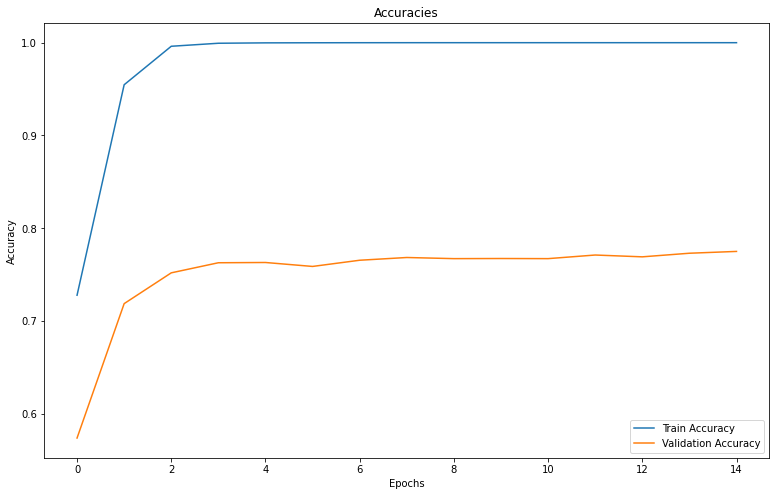

In [39]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_1"], label = "Train Accuracy")
plt.plot(history.history["val_auc_1"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

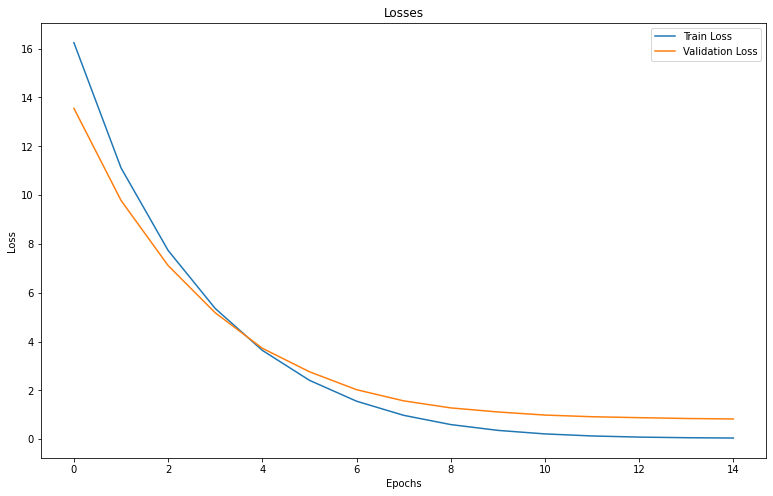

In [40]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()